<h3 align="center">Programa de Pós-graduação em Engenharia Elétrica e de Computação<br>
Disciplina: Processamento Digital de Imagens </h3>

<h3 align="center">Trabalho 03: Segmentação de Imagens<br>
Discente: Alan Marques da Rocha

---

## 1. Importando as bibliotecas necessárias para o projeto

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pathlib
import glob
import os

from cv2 import watershed

from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed



### 1.1 Carregando as imagens diretamente do diretório raiz

In [2]:
# Função que carrega as imagens da base de dados
def carrega_img(dir_imgs):
    imgs_array = []
    path = os.path.join(dir_imgs)
    path_list  = list(os.listdir(path))
    for imgs in path_list:
        imgs_array.append(cv2.imread(os.path.join(path, imgs)))
    return imgs_array

# Guarda as imagens em uma lista
imagens = carrega_img('imagens_cor_segmentacao')


### 1.2 Função que exibe as imagens em uma grid

In [50]:
def showMultipleImages(imgsArray, titlesArray, size, x, y, mincolor = 0, maxcolor = 255):
    if(x < 1 or y < 1):
        print("ERRO: X e Y não podem ser zero ou abaixo de zero!")
        return
    elif(x == 1 and y == 1):
        showSingleImage(imgsArray, titlesArray)
    elif(x == 1):
        fig, axis = plt.subplots(y, figsize = size)
        yId = 0
        for img in imgsArray:
            axis[yId].imshow(img, cmap = 'gray', vmin = mincolor, vmax = maxcolor);
            axis[yId].set_anchor('NW')
            axis[yId].set_title(titlesArray[yId], fontdict = {'fontsize': 10, 'fontweight': 'medium'}, pad = 10)

            yId += 1
    elif(y == 1):
        fig, axis = plt.subplots(1, x, figsize = size)
        fig.suptitle(titlesArray)
        xId = 0
        for img in imgsArray:
            axis[xId].imshow(img, cmap = 'gray', vmin = mincolor, vmax = maxcolor)
            axis[xId].set_anchor('NW')
            axis[xId].set_title(titlesArray[xId], fontdict = {'fontsize': 10, 'fontweight': 'medium'}, pad = 10)

            xId += 1
    else:
        fig, axis = plt.subplots(y, x, figsize = size);
        xId, yId, titleId = 0, 0, 0
        for img in imgsArray:
            axis[yId, xId].set_title(titlesArray[titleId], fontdict = {'fontsize': 12, 'fontweight': 'medium'}, pad = 10)
            axis[yId, xId].set_anchor('NW')
            axis[yId, xId].imshow(img, cmap = 'gray', vmin = mincolor, vmax = maxcolor)
            if(len(titlesArray[titleId]) == 0):
                axis[yId, xId].axis('off')

            titleId += 1
            xId += 1
            if xId == x:
                xId = 0
                yId += 1
    plt.show();

## 2. Convertendo as imagens de ``BGR`` para ``RGB``

In [64]:
# Função que transforma as imagens em níveis BGR p/ RGB.
def bgr_rgb(i):
    img = cv2.cvtColor(imagens[i], cv2.COLOR_BGR2RGB)
    return img

# Guardando as imagens nas novas variáveis.
img_0 = bgr_rgb(0); img_1 = bgr_rgb(1); img_2 = bgr_rgb(2); img_3 = bgr_rgb(3); img_4 = bgr_rgb(4); img_5 = bgr_rgb(5)


### 2.1 Transformando as imagens para níveis de cinza
    

In [5]:
# Função que transforma as imagens de RGB p/ GRAY
def rgb_gray(j):
    img_gray = cv2.cvtColor(imagens[j], cv2.COLOR_RGB2GRAY)
    return img_gray

# Guardando as imagens nas novas variáveis.
img_0_gray = rgb_gray(0); img_1_gray = rgb_gray(1); img_2_gray = rgb_gray(2); 
img_3_gray = rgb_gray(3); img_4_gray = rgb_gray(4); img_5_gray = rgb_gray(5)




## 3. Métodos propostos: ``Otsu``, ``K-means``, ``Watershed`` e ``Region Growing``

### 3.1 Método de Otsu

In [62]:

# Função que retorna o valor do limiar de otsu e realiza a conversão da imagem aplicando o threshold binary + otsu:
def lim_otsu(imagem):
    valor, otsu = cv2.threshold(imagem, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    print(valor)
    return otsu


# Guardando as imagens nas novas variáveis.
img_0_otsu = lim_otsu(img_0_gray); img_1_otsu = lim_otsu(img_1_gray); img_2_otsu = lim_otsu(img_2_gray); img_3_otsu = lim_otsu(img_3_gray); 

img_4_otsu = lim_otsu(img_4_gray); img_5_otsu = lim_otsu(img_5_gray);



77.0
97.0
111.0
101.0
98.0
154.0


### 3.2 Método de Watershed

### 3.2.1 Fazendo a implementação do método de ``THRESH_BINARY_INV``

In [53]:
# Função que retorna o valor do limiar de otsu_inv e realiza a conversão da imagem aplicando o threshold binary + otsu_inv:
def lim_inv(imagem):
    valor, otsu_inv = cv2.threshold(imagem, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    print(valor)
    return otsu_inv


# Guardando as imagens nas novas variáveis.
img_0_inv = lim_inv(img_0_gray); img_1_inv = lim_inv(img_1_gray); img_2_inv = lim_inv(img_2_gray); img_3_inv = lim_inv(img_3_gray); 

img_4_inv = lim_inv(img_4_gray); img_5_inv = lim_inv(img_5_gray);


77.0
97.0
111.0
101.0
98.0
154.0


### 3.2.2 Implementando o método ``watershed``


In [54]:
def img_watershed(imagem, img_original):
    
    otsu_inv = cv2.threshold(imagem, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    # realizando operações morfologicas:
    seg = cv2.erode(otsu_inv, np.ones((3,3), np.uint8), iterations = 3)
    
    # imagem de mapa da distância Euclidiana
    dist = ndi.distance_transform_edt(seg)
    
    local_max = peak_local_max(dist, indices = False, min_distance = 20, labels = seg)
    
    markers = ndi.label(local_max, structure=np.ones((3,3)))[0]
    
    
    labels = watershed(-dist, markers, mask = seg)
    
    cmap = plt.cm.jet

    # processo de normalização da escala de cores
    norm = plt.Normalize(vmin=labels.min(), vmax = labels.max())

    seg_watershed = cmap(norm(labels))

    seg_watershed = ((seg_watershed * 255).astype(np.uint8))

    # Transformando a imagem de RGB p/ BGR voltando ao original
    seg_watershed = cv2.cvtColor(seg_watershed, cv2.COLOR_RGB2BGR)
    
    
    # sobreposição da imagem segmentada sob a imagem original
    img_sobreposicao = cv2.addWeighted(seg_watershed, 0.5, img_original, 0.5, 0)

    return img_sobreposicao


img_wshed_0 = img_watershed(img_0_gray, img_0); img_wshed_1 = img_watershed(img_1_gray, img_1); img_wshed_2 = img_watershed(img_2_gray, img_2); img_wshed_3 = img_watershed(img_3_gray, img_3); 
img_wshed_4 = img_watershed(img_4_gray, img_4); img_wshed_5 = img_watershed(img_5_gray, img_5); 


C:\Users\COGEV\AppData\Local\Temp\ipykernel_17368\2589477393.py:11: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(dist, indices = False, min_distance = 20, labels = seg)


## 4. Crescimento de Regiões

## 5. K-means

#### Preparando os dados para ``K médias``. A imagem é uma forma tridimensional (x, y, z), mas para aplicar o agrupamento de ``k-means`` é necessário reformulá-la para uma ``matriz bidimensional.``

In [55]:
def kmedia(imagem):
    # Reformulando a imagem para um array bidimensional
    new_pixels = imagem.reshape((-1,3))
 
    # Convert to float type
    new_pixels = np.float32(new_pixels)
    
    # a linha de código abaixo define os critérios para o algoritmo parar de funcionar,
    # o que acontecerá é que 100 iterações sejam executadas ou o epsilon (que é a precisão necessária)
    # torna-se 85%
    criterio = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.70)
 
    # então realiza o agrupamento k-means com h número de agrupamentos definido como k = n
    # centros aleatórios são inicialmente escolhidos para o agrupamento
    k = 8
    retval, labels, centers = cv2.kmeans(new_pixels, k, None, criterio, 10, cv2.KMEANS_RANDOM_CENTERS)
 
    # converte dos dados para 8-bits
    centers = np.uint8(centers)
    seg_data = centers[labels.flatten()]
 
    # reformula os dados dentro das dimensões originais na imagem
    seg_image = seg_data.reshape((imagem.shape))
    
    return seg_image

# Guardando as imagens nas novas variáveis.
img_0_kmeans = kmedia(img_0); img_1_kmeans = kmedia(img_1); img_2_kmeans = kmedia(img_2); img_3_kmeans = kmedia(img_3); 

img_4_kmeans = kmedia(img_4); img_5_kmeans = kmedia(img_5); 


## 6. Resultados Obtidos:

### 6.1 Resultados para a Figura 1

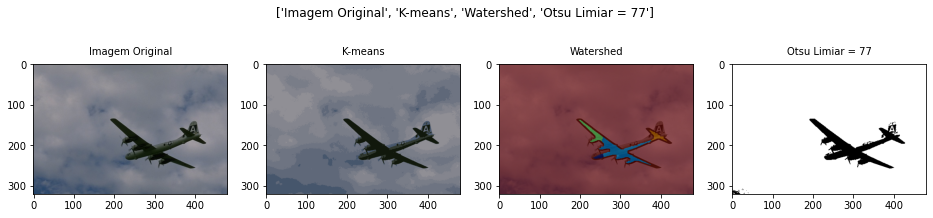

In [66]:
imgsArray = [img_0, img_0_kmeans, img_wshed_0, img_0_otsu]
titlesArray = ['Imagem Original', 'K-means', 'Watershed', 'Otsu (Limiar = 77)']
showMultipleImages(imgsArray, titlesArray, (16,8), 4, 1)

### 6.2 Resultados para a Figura 2

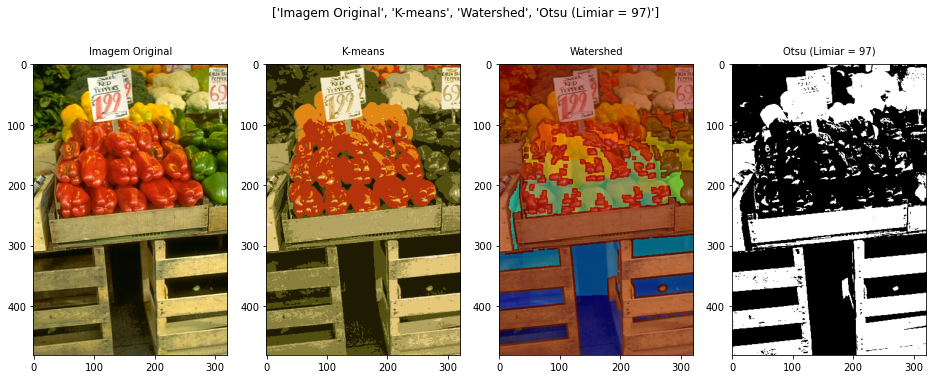

In [67]:
imgsArray = [img_1, img_1_kmeans, img_wshed_1, img_1_otsu]
titlesArray = ['Imagem Original', 'K-means', 'Watershed', 'Otsu (Limiar = 97)']
showMultipleImages(imgsArray, titlesArray, (16,8), 4, 1)

### 6.3 Resultados para a Figura 3

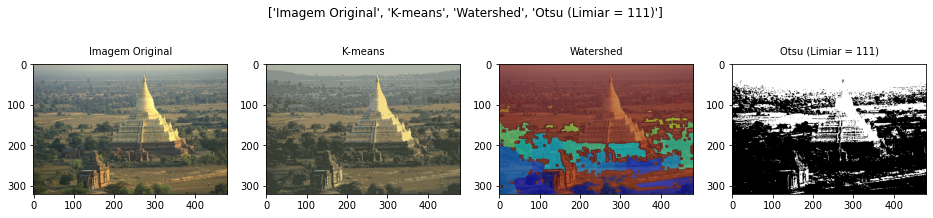

In [68]:
imgsArray = [img_2, img_2_kmeans, img_wshed_2, img_2_otsu]
titlesArray = ['Imagem Original', 'K-means', 'Watershed', 'Otsu (Limiar = 111)']
showMultipleImages(imgsArray, titlesArray, (16,8), 4, 1)

### 6.4 Resultados para a Figura 4

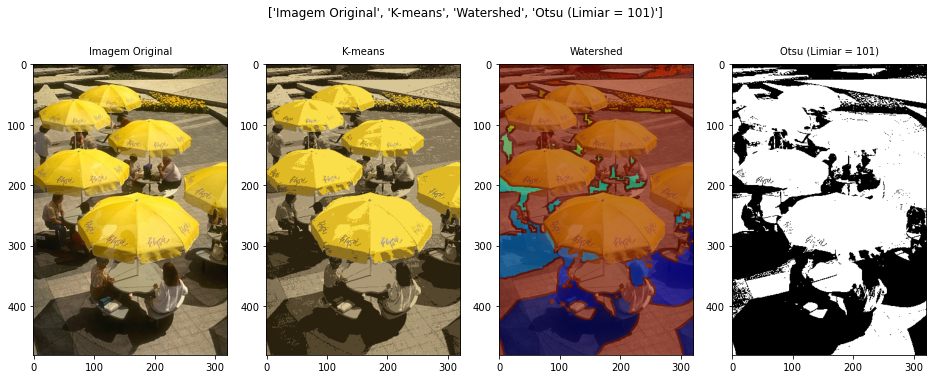

In [69]:
imgsArray = [img_3, img_3_kmeans, img_wshed_3, img_3_otsu]
titlesArray = ['Imagem Original', 'K-means', 'Watershed', 'Otsu (Limiar = 101)']
showMultipleImages(imgsArray, titlesArray, (16,8), 4, 1)

### 6.5 Resultados para a Figura 5

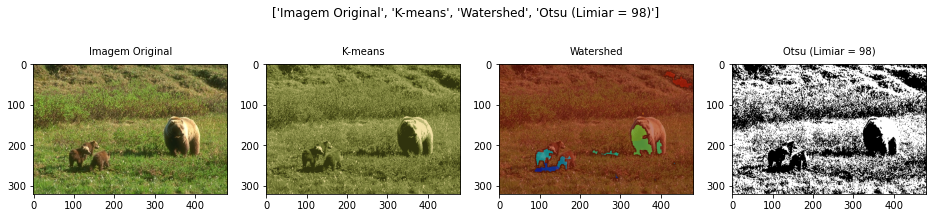

In [70]:
imgsArray = [img_4, img_4_kmeans, img_wshed_4, img_4_otsu]
titlesArray = ['Imagem Original', 'K-means', 'Watershed', 'Otsu (Limiar = 98)']
showMultipleImages(imgsArray, titlesArray, (16, 8), 4, 1)

### 6.6 Resultados para a Figura 6

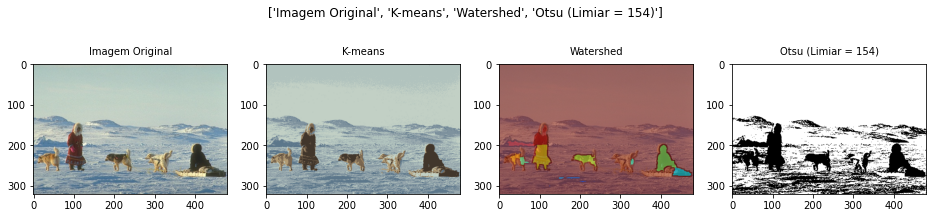

In [71]:
imgsArray = [img_5, img_5_kmeans, img_wshed_5, img_5_otsu]
titlesArray = ['Imagem Original', 'K-means', 'Watershed', 'Otsu (Limiar = 154)']
showMultipleImages(imgsArray, titlesArray, (16,8), 4, 1)